## Простое обучение

### Подгружаем нужные библиотеки

In [1]:
import torch
import os
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.models.resnet import ResNet18_Weights
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import subprocess

### Качаем данные

In [2]:
!wget http://www.soshnikov.com/permanent/data/petfaces.tar.gz
!tar xfz petfaces.tar.gz
!rm petfaces.tar.gz

--2024-10-03 01:54:54--  http://www.soshnikov.com/permanent/data/petfaces.tar.gz
Resolving www.soshnikov.com (www.soshnikov.com)... 79.137.227.122
Connecting to www.soshnikov.com (www.soshnikov.com)|79.137.227.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24483412 (23M) [application/x-tar]
Saving to: ‘petfaces.tar.gz’

petfaces.tar.gz     100%[===================>]  23.35M   226KB/s    in 1m 49s  

2024-10-03 01:56:43 (220 KB/s) - ‘petfaces.tar.gz’ saved [24483412/24483412]



In [3]:
target_path = 'petfaces'

### Предобработка данных

In [4]:
def get_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def load_dataset(path, transform):
    return torchvision.datasets.ImageFolder(root=path, transform=transform)

def split_dataset(dataset, test_size=0.2):
    targets = [y for _, y in dataset.samples]
    train_idx, test_idx = train_test_split(
        np.arange(len(targets)),
        test_size=test_size,
        stratify=targets
    )
    return torch.utils.data.Subset(dataset, train_idx), torch.utils.data.Subset(dataset, test_idx)

def create_data_loaders(train_dataset, test_dataset, batch_size=64):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

transform = get_transforms()
dataset = load_dataset(target_path, transform)
train_dataset, test_dataset = split_dataset(dataset)
train_loader, test_loader = create_data_loaders(train_dataset, test_dataset)


### Обучение модели

In [5]:
class PetNet(nn.Module):
    def __init__(self):
        super(PetNet, self).__init__()
        self.features = self._create_backbone()
        self.classifier = self._create_classifier(36)  # Классификатор для пород
        self.binary_classifier = self._create_classifier(2)  # Бинарный классификатор для кошек и собак

    def _create_backbone(self):
        """Создает основу модели на базе ResNet-18."""
        backbone = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        return nn.Sequential(*list(backbone.children())[:-1])  # Удаляем последний слой

    def _create_classifier(self, num_classes):
        """Создает линейный классификатор с указанным числом классов."""
        return nn.Linear(models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).fc.in_features, num_classes)

    def forward(self, x):
        """Прямой проход через модель."""
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Преобразуем для линейного классификатора
        breed = self.classifier(x)
        binary = self.binary_classifier(x)
        return breed, binary

# Перемещение модели на устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PetNet().to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


In [6]:
def create_loss_function():
    return nn.CrossEntropyLoss()

def create_optimizer(model, lr=0.001):
    return optim.Adam(model.parameters(), lr=lr)

criterion = create_loss_function()
optimizer = create_optimizer(model)

In [8]:
def create_loss_function():
    return nn.CrossEntropyLoss()

def create_optimizer(model, lr=0.001):
    return optim.Adam(model.parameters(), lr=lr)

def compute_loss(model, images, labels, criterion):
    breed_outputs, binary_outputs = model(images)
    loss_breed = criterion(breed_outputs, labels)
    loss_binary = criterion(binary_outputs, labels % 2)
    total_loss = loss_breed + loss_binary
    return total_loss

def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            loss = compute_loss(model, images, labels, criterion)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Loss: {average_loss:.4f}')

criterion = create_loss_function()
optimizer = create_optimizer(model)
train_model(model, train_loader, criterion, optimizer, 10)

Epoch 1, Loss: 0.9689
Epoch 2, Loss: 0.4105
Epoch 3, Loss: 0.3621
Epoch 4, Loss: 0.3450
Epoch 5, Loss: 0.1709
Epoch 6, Loss: 0.0785
Epoch 7, Loss: 0.0929
Epoch 8, Loss: 0.1523
Epoch 9, Loss: 0.3322
Epoch 10, Loss: 0.3680


### Оценка модели

In [9]:
def create_class_names():
    return {
        0: 'cat_Abyssinian', 1: 'cat_Bengal', 2: 'cat_Birman', 3: 'cat_Bombay', 4: 'cat_British',
        5: 'cat_Egyptian', 6: 'cat_Maine', 7: 'cat_Persian', 8: 'cat_Ragdoll', 9: 'cat_Russian',
        10: 'cat_Siamese', 11: 'cat_Sphynx', 12: 'dog_american', 13: 'dog_basset', 14: 'dog_beagle',
        15: 'dog_boxer', 16: 'dog_chihuahua', 17: 'dog_english', 18: 'dog_german', 19: 'dog_great',
        20: 'dog_havanese', 21: 'dog_japanese', 22: 'dog_keeshond', 23: 'dog_leonberger',
        24: 'dog_miniature', 25: 'dog_newfoundland', 26: 'dog_pomeranian', 27: 'dog_pug',
        28: 'dog_saint', 29: 'dog_samoyed', 30: 'dog_scottish', 31: 'dog_shiba', 32: 'dog_staffordshire',
        33: 'dog_wheaten', 34: 'dog_yorkshire'
    }

def create_binary_names():
    return {0: 'Cat', 1: 'Dog'}

class_names = create_class_names()
binary_names = create_binary_names()


Breed Classification Accuracy:  0.7884914463452566
Binary Classification Accuracy:  0.8973561430793157


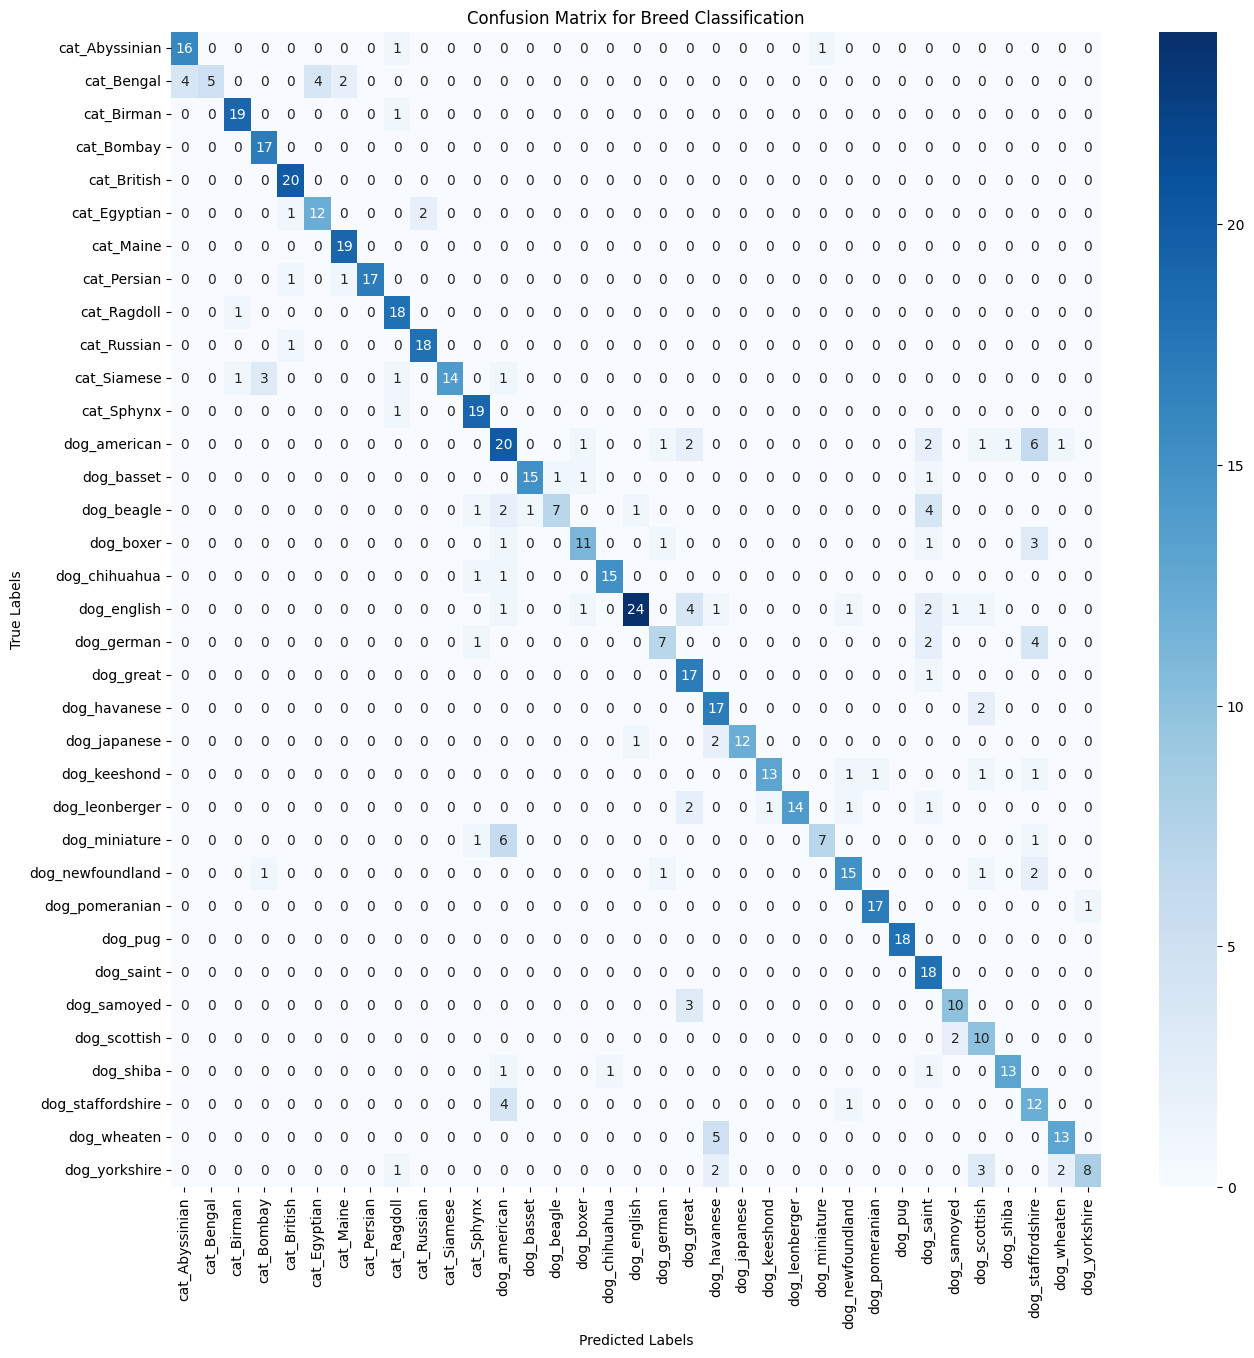

In [10]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels, all_preds_breed, all_preds_binary = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            breed_outputs, binary_outputs = model(images)
            all_labels.extend(labels.cpu().numpy())
            all_preds_breed.extend(get_predictions(breed_outputs))
            all_preds_binary.extend(get_predictions(binary_outputs))

    all_labels = np.array(all_labels)
    all_preds_breed = np.array(all_preds_breed)
    all_preds_binary = np.array(all_preds_binary)

    breed_accuracy = accuracy_score(all_labels, all_preds_breed)
    binary_accuracy = accuracy_score(all_labels % 2, all_preds_binary)

    print_accuracies(breed_accuracy, binary_accuracy)

    breed_conf_matrix = confusion_matrix(all_labels, all_preds_breed)
    plot_confusion_matrix(breed_conf_matrix)

def get_predictions(outputs):
    _, preds = torch.max(outputs, 1)
    return preds.cpu().numpy()

def print_accuracies(breed_accuracy, binary_accuracy):
    """Выводит точности классификации."""
    print("Breed Classification Accuracy: ", breed_accuracy)
    print("Binary Classification Accuracy: ", binary_accuracy)

def plot_confusion_matrix(conf_matrix):
    """Строит и отображает матрицу ошибок."""
    class_names_list = list(class_names.values())
    plt.figure(figsize=(15, 15))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names_list, yticklabels=class_names_list)
    plt.title('Confusion Matrix for Breed Classification')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

evaluate_model(model, test_loader, device)

In [11]:
def calculate_topk_accuracy(model, loader, k=3):
    """Вычисляет точность модели по топ-K предсказаниям."""
    model.eval()
    total_correct = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)[0]
            total_correct += count_correct_topk(output, target, k)

    topk_acc = total_correct / len(loader.dataset)
    return topk_acc

def count_correct_topk(output, target, k):
    """Считает количество правильных предсказаний в топ-K."""
    _, predictions = output.topk(k, dim=1)
    return predictions.eq(target.view(-1, 1).expand_as(predictions)).sum().item()

# Вычисление и вывод точности топ-3
top3_accuracy = calculate_topk_accuracy(model, test_loader, k=3)
print(f'Top-3 Accuracy: {top3_accuracy * 100:.2f}%')


Top-3 Accuracy: 94.09%


### Показ результата

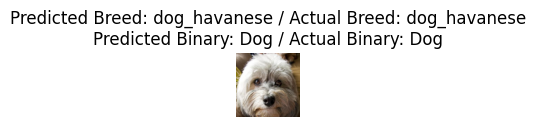

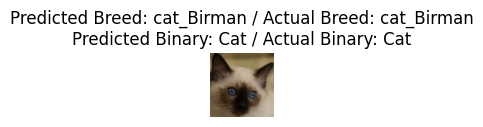

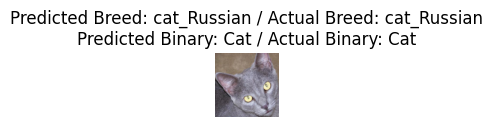

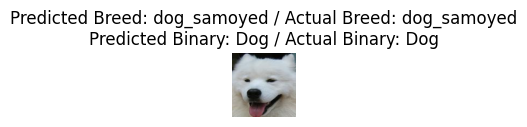

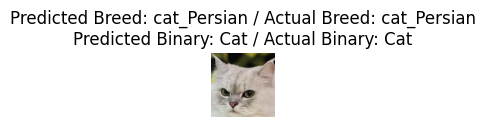

In [14]:
def imshow(image_tensor, title=None):
    image = image_tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001)

def get_prediction_labels(preds, labels):
    predicted_breed = class_names[preds[0].item()]
    actual_breed = class_names[labels[0].item()]
    predicted_binary = binary_names[1 if preds[0].item() >= 12 else 0]
    actual_binary = binary_names[1 if labels[0].item() >= 12 else 0]
    return predicted_breed, actual_breed, predicted_binary, actual_binary

def visualize_model(model, num_images=1):
    was_training = model.training
    model.eval()
    images_so_far = 0

    indices = random.sample(range(len(test_dataset)), num_images)

    with torch.no_grad():
        for i in indices:
            inputs, labels = test_dataset[i]
            inputs = inputs.unsqueeze(0).to(device)
            labels = torch.tensor([labels]).to(device)

            breed_outputs, binary_outputs = model(inputs)
            _, breed_preds = torch.max(breed_outputs, 1)
            _, binary_preds = torch.max(binary_outputs, 1)

            images_so_far += 1
            ax = plt.subplot(num_images, 1, images_so_far)
            ax.axis('off')

            predicted_breed, actual_breed, predicted_binary, actual_binary = get_prediction_labels(breed_preds, labels)

            ax.set_title(f'Predicted Breed: {predicted_breed} / Actual Breed: {actual_breed}\n'
                         f'Predicted Binary: {predicted_binary} / Actual Binary: {actual_binary}')
            imshow(inputs.cpu().squeeze(0))

    model.train(mode=was_training)

visualize_model(model, num_images=5)
